In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import scipy.cluster.hierarchy as sch
from sklearn. preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from yellowbrick.cluster import KElbowVisualizer

In [2]:
df=pd.read_csv("bank_transactions.csv")
df.head(10)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.00
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.00
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.00
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.00
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.50
5,T6,C1536588,8/10/72,F,ITANAGAR,53609.20,2/8/16,173940,676.00
6,T7,C7126560,26/1/92,F,MUMBAI,973.46,2/8/16,173806,566.00
7,T8,C1220223,27/1/82,M,MUMBAI,95075.54,2/8/16,170537,148.00
8,T9,C8536061,19/4/88,F,GURGAON,14906.96,2/8/16,192825,833.00
9,T10,C6638934,22/6/84,M,MUMBAI,4279.22,2/8/16,192446,289.11


In [3]:
df.drop(columns=['TransactionTime'],inplace=True)

In [4]:
#check uniqueness of Customer ID
check_cust_id = df["CustomerID"].value_counts()

In [5]:
df[df["CustomerID"].isin(check_cust_id.index[check_cust_id.gt(2)])].sort_values(by=['CustomerID'])

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionAmount (INR)
888199,T888200,C1010041,13/7/92,F,LOHIT,1290.76,7/9/16,20.00
957662,T957663,C1010041,6/9/93,F,DELHI,34119.48,10/9/16,14500.00
113532,T113533,C1010041,14/9/75,F,NOIDA,746731.94,6/8/16,2397.00
329016,T329017,C1010081,2/9/77,F,PANCHKULA,23319.04,15/8/16,1699.00
347495,T347496,C1010081,1/5/89,M,GHAZIABAD,1584.18,14/8/16,429.00
...,...,...,...,...,...,...,...,...
906378,T906379,C9042817,24/9/92,F,DELHI,1754.36,12/9/16,163.12
46326,T46327,C9042817,1/1/93,M,GUWAHATI,3690.99,3/8/16,500.00
117527,T117528,C9042847,9/3/90,M,CHAMRAJNAGAR,2831.77,6/8/16,200.00
134300,T134301,C9042847,23/2/89,M,AURANGABAD,38118.03,5/8/16,145.00


In [6]:
check_cust_id

C5533885    6
C6624352    6
C1736254    6
C6735477    6
C1113684    6
           ..
C8716232    1
C4474828    1
C3341662    1
C6821983    1
C6420483    1
Name: CustomerID, Length: 884265, dtype: int64

In [7]:
df[df["CustomerID"] == "C5533885"]

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionAmount (INR)
28272,T28273,C5533885,10/7/90,M,KOLKATA,9283.45,25/9/16,108.00
49914,T49915,C5533885,10/7/90,M,KOLKATA,9283.45,3/8/16,499.00
169107,T169108,C5533885,1/1/1800,M,NEW DELHI,3307.89,4/8/16,1.00
308974,T308975,C5533885,22/5/88,M,THANE WEST,20845.31,10/8/16,918.86
481046,T481047,C5533885,22/5/88,M,THANE WEST,20845.31,21/8/16,1180.68
705114,T705115,C5533885,28/7/64,M,DELHI,74967.38,31/8/16,147.00


In [8]:
# Begin Data Cleaning
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 8 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), object(6)
memory usage: 64.0+ MB


In [9]:
df.isnull().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionAmount (INR)       0
dtype: int64

In [10]:
df.dropna(inplace=True)
df.duplicated().sum()

0

In [11]:
df = df.loc[~(df['CustomerDOB'] == '1/1/1800')]

In [12]:
# convert type of columns TransactionDate,CustomerDOB from string to datetime
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format = '%d/%m/%y')
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], format = '%d/%m/%y')

In [13]:
# Calculate Age
df['CustomerAge'] =df['TransactionDate'].dt.year - df['CustomerDOB'].dt.year
df.sort_values(by=['CustomerAge'])

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionAmount (INR),CustomerAge
398485,T398486,C3422435,2068-08-04,M,KOLKATA,303144.19,2016-08-18,4240.0,-52
137931,T137932,C7413571,2068-12-31,F,ALIGARH,1051.31,2016-08-05,14.0,-52
1045041,T1045042,C1110364,2068-02-09,M,NASHIK,455.31,2016-09-18,2200.0,-52
803419,T803420,C8642378,2068-10-25,M,NEW DELHI,240297.63,2016-09-05,200.0,-52
318157,T318158,C7427949,2068-05-02,F,CHENNAI,566676.95,2016-08-10,1900.0,-52
...,...,...,...,...,...,...,...,...,...
787809,T787810,C2222388,1969-07-02,M,SAHARANPUR,18044.12,2016-09-06,50.0,47
817899,T817900,C6450683,1969-02-16,M,MUMBAI,222327.42,2016-09-04,1500.0,47
370935,T370936,C7932487,1969-03-15,M,SILIGURI,107650.52,2016-08-14,2091.0,47
405454,T405455,C8219120,1969-08-05,M,NEW DELHI,511.22,2016-08-18,2000.0,47


In [14]:
set(df.sort_values(by=['CustomerAge']).CustomerAge.values)

{-52,
 -51,
 -50,
 -49,
 -48,
 -47,
 -46,
 -45,
 -44,
 -43,
 -42,
 -41,
 -40,
 -39,
 -38,
 -37,
 -36,
 -35,
 -34,
 -33,
 -32,
 -31,
 -30,
 -29,
 -28,
 -27,
 -26,
 -25,
 -24,
 -23,
 -22,
 -21,
 -20,
 -19,
 -18,
 -17,
 -16,
 -15,
 -14,
 -13,
 -12,
 -11,
 -10,
 -9,
 -8,
 -7,
 -6,
 -5,
 -4,
 -3,
 -2,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47}

In [15]:
df[df.CustomerAge == -6]

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionAmount (INR),CustomerAge
426655,T426656,C7242435,2022-10-20,M,KANPUR,6832.02,2016-08-17,1420.0,-6
431655,T431656,C6842464,2022-10-20,M,KANPUR,6832.02,2016-08-17,1420.0,-6
890876,T890877,C7642474,2022-10-20,M,KANPUR,6832.02,2016-09-07,350.0,-6


In [16]:
df = df[df['CustomerAge']>= -5]
df = df.reset_index(drop=True)
df.sort_values(by=['CustomerID'])

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionAmount (INR),CustomerAge
154028,T173509,C1010011,1983-08-05,M,NEW DELHI,120180.54,2016-08-09,356.0,33
29533,T33671,C1010011,1992-08-19,F,NOIDA,32500.73,2016-09-26,4750.0,24
323178,T363022,C1010012,1994-07-28,M,MUMBAI,24204.49,2016-08-14,1499.0,22
78964,T89544,C1010014,1992-06-04,F,MUMBAI,38377.14,2016-08-01,1205.0,24
223953,T251648,C1010014,1984-08-19,M,MUMBAI,161848.76,2016-08-07,250.0,32
...,...,...,...,...,...,...,...,...,...
201015,T226394,C9099836,1990-12-24,M,BHIWANDI,133067.23,2016-08-07,691.0,26
870799,T980444,C9099877,1996-06-09,M,BANGALORE,96063.46,2016-09-15,222.0,20
357382,T401232,C9099919,1993-10-21,M,GUNTUR,5559.75,2016-08-18,126.0,23
583710,T659168,C9099941,1995-04-22,M,CHENNAI,35295.92,2016-08-28,50.0,21


In [17]:
df.CustGender.value_counts()

M    673867
F    257331
Name: CustGender, dtype: int64

In [18]:
df['TransactionDate'].value_counts()

2016-08-07    24747
2016-08-13    24130
2016-08-06    24051
2016-09-04    24039
2016-09-03    23855
2016-09-10    23182
2016-09-11    22982
2016-08-14    22766
2016-08-15    21701
2016-09-02    20494
2016-08-21    20455
2016-09-01    20024
2016-08-12    19955
2016-08-09    19446
2016-09-08    19368
2016-08-10    19337
2016-08-11    19310
2016-09-09    19260
2016-09-05    18999
2016-09-07    18891
2016-08-27    18859
2016-08-05    18858
2016-08-20    18829
2016-08-28    18709
2016-08-17    18644
2016-08-02    18629
2016-08-08    18549
2016-08-04    18435
2016-09-12    18345
2016-09-13    18293
2016-08-03    18224
2016-08-01    18178
2016-08-16    17981
2016-09-14    17521
2016-09-15    17506
2016-09-06    17488
2016-08-31    17284
2016-08-18    17252
2016-08-19    16379
2016-08-22    16315
2016-08-25    16273
2016-08-24    15637
2016-08-26    15479
2016-08-30    15101
2016-08-23    15071
2016-08-29    14577
2016-09-18    13110
2016-09-26    10863
2016-09-25     7352
2016-09-27     6518


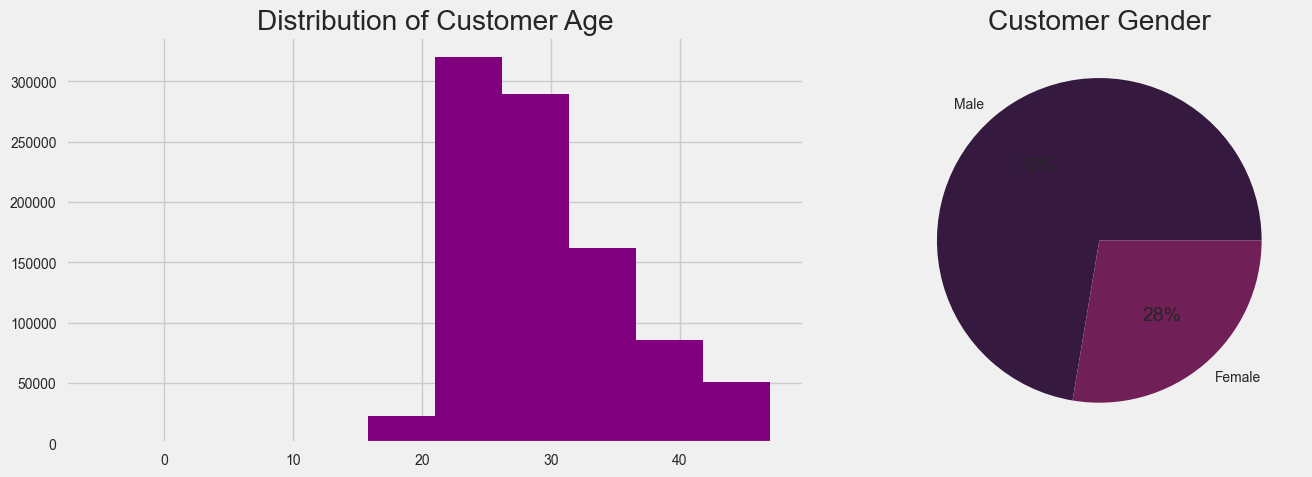

In [23]:
# EDA 1: Compare based on Gender and/or Age
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,5))
palette_color = sns.color_palette('rocket')
ax[0].hist(x=df['CustomerAge'],color='purple')
ax[0].set_title("Distribution of Customer Age")
ax[1].pie(df['CustGender'].value_counts(),autopct='%1.f%%',colors=palette_color,labels=['Male','Female'])
ax[1].set_title("Customer Gender")
plt.tight_layout()

In [24]:
male_df = df[df.CustGender == "M"]
female_df = df[df.CustGender == "F"]

child_df = df[df.CustomerAge < 13]
teen_df = df[ (df['CustomerAge'] >= 13) & (df['CustomerAge'] <= 17) ]
unstable_adult_df = df[ (df['CustomerAge'] >= 18) & (df['CustomerAge'] <= 29) ]
stable_adult_df = df[df['CustomerAge'] >= 30]

male_child_df = male_df[male_df.CustomerAge < 13]
male_teen_df = male_df[ (male_df['CustomerAge'] >= 13) & (male_df['CustomerAge'] <= 17) ]
male_unstable_adult_df = male_df[ (male_df['CustomerAge'] >= 18) & (male_df['CustomerAge'] <= 29) ]
male_stable_adult_df = male_df[male_df['CustomerAge'] >= 30]

female_child_df = female_df[female_df.CustomerAge < 13]
female_teen_df = female_df[ (female_df['CustomerAge'] >= 13) & (female_df['CustomerAge'] <= 17) ]
female_unstable_adult_df = female_df[ (female_df['CustomerAge'] >= 18) & (female_df['CustomerAge'] <= 29) ]
female_stable_adult_df = female_df[female_df['CustomerAge'] >= 30]

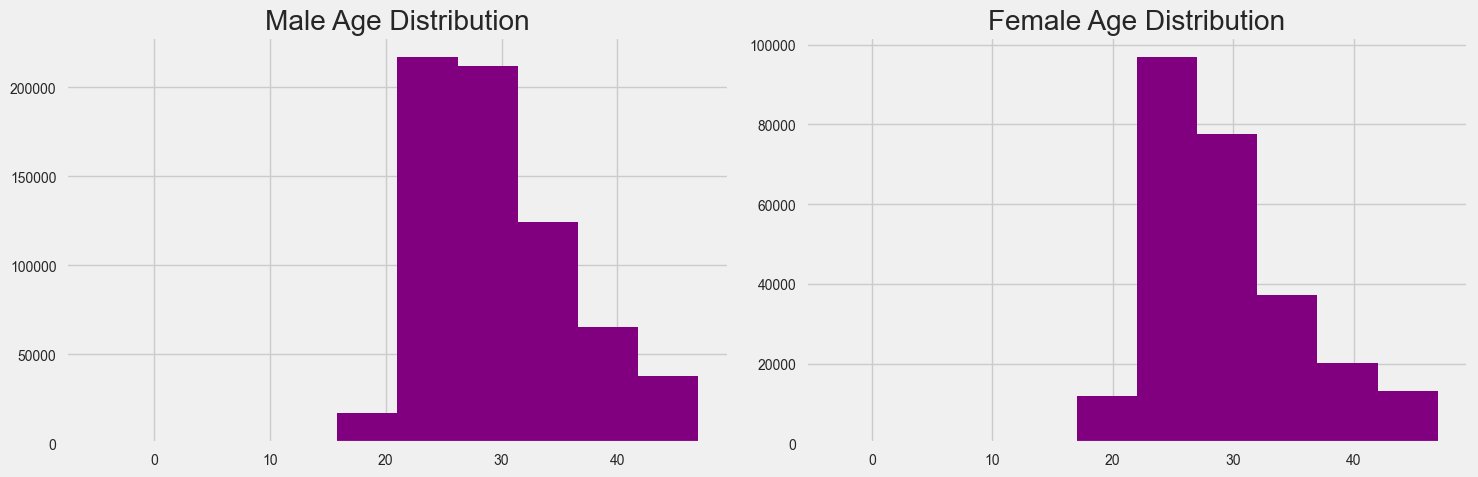

In [26]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,5))
palette_color = sns.color_palette('rocket')
ax[0].hist(x=male_df['CustomerAge'],color='purple')
ax[0].set_title("Male Age Distribution")
ax[1].hist(x=female_df['CustomerAge'],color='purple')
ax[1].set_title("Female Age Distribution")
plt.tight_layout()

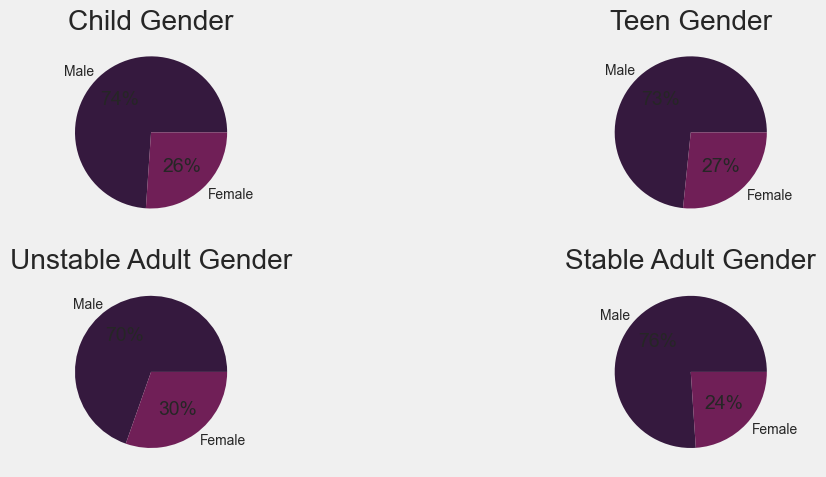

In [29]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(15,5))
palette_color = sns.color_palette('rocket')
ax[0][0].pie(child_df['CustGender'].value_counts(),autopct='%1.f%%',colors=palette_color,labels=['Male','Female'])
ax[0][0].set_title("Child Gender")
ax[0][1].pie(teen_df['CustGender'].value_counts(),autopct='%1.f%%',colors=palette_color,labels=['Male','Female'])
ax[0][1].set_title("Teen Gender")
ax[1][0].pie(unstable_adult_df['CustGender'].value_counts(),autopct='%1.f%%',colors=palette_color,labels=['Male','Female'])
ax[1][0].set_title("Unstable Adult Gender")
ax[1][1].pie(stable_adult_df['CustGender'].value_counts(),autopct='%1.f%%',colors=palette_color,labels=['Male','Female'])
ax[1][1].set_title("Stable Adult Gender")
plt.tight_layout()

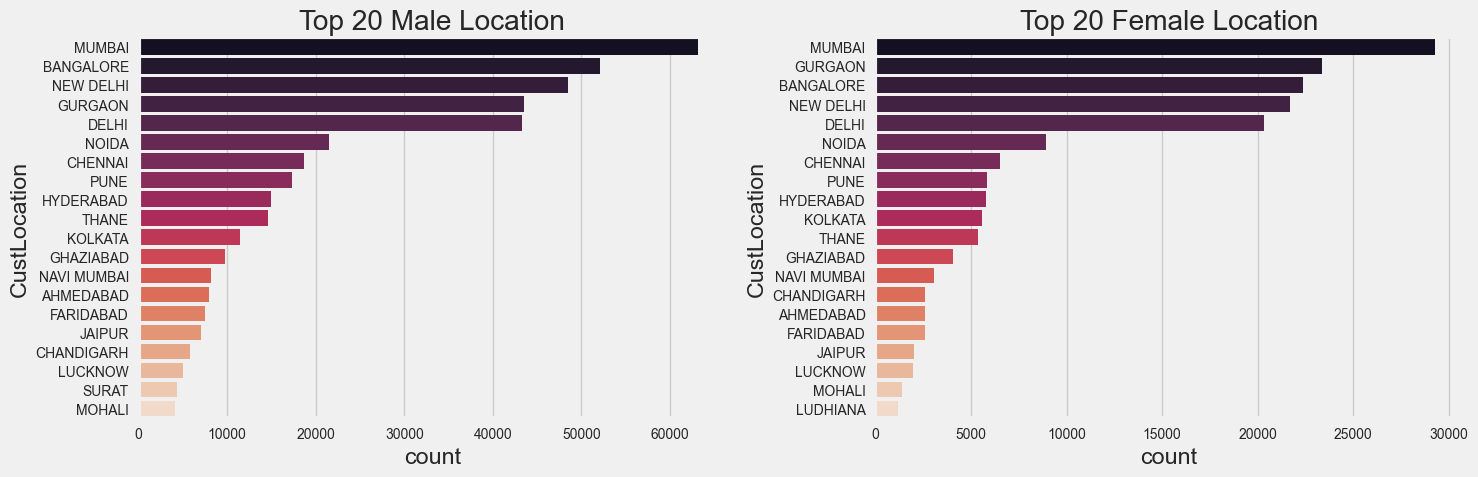

In [48]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,5))
palette_color = sns.color_palette('rocket')
sns.countplot(y='CustLocation',data=male_df,palette='rocket', order = male_df['CustLocation'].value_counts()[:20].index, ax=ax[0])
sns.countplot(y='CustLocation',data=female_df,palette='rocket', order = female_df['CustLocation'].value_counts()[:20].index, ax=ax[1])
ax[0].set_title("Top 20 Male Location")
ax[1].set_title("Top 20 Female Location")
plt.tight_layout()

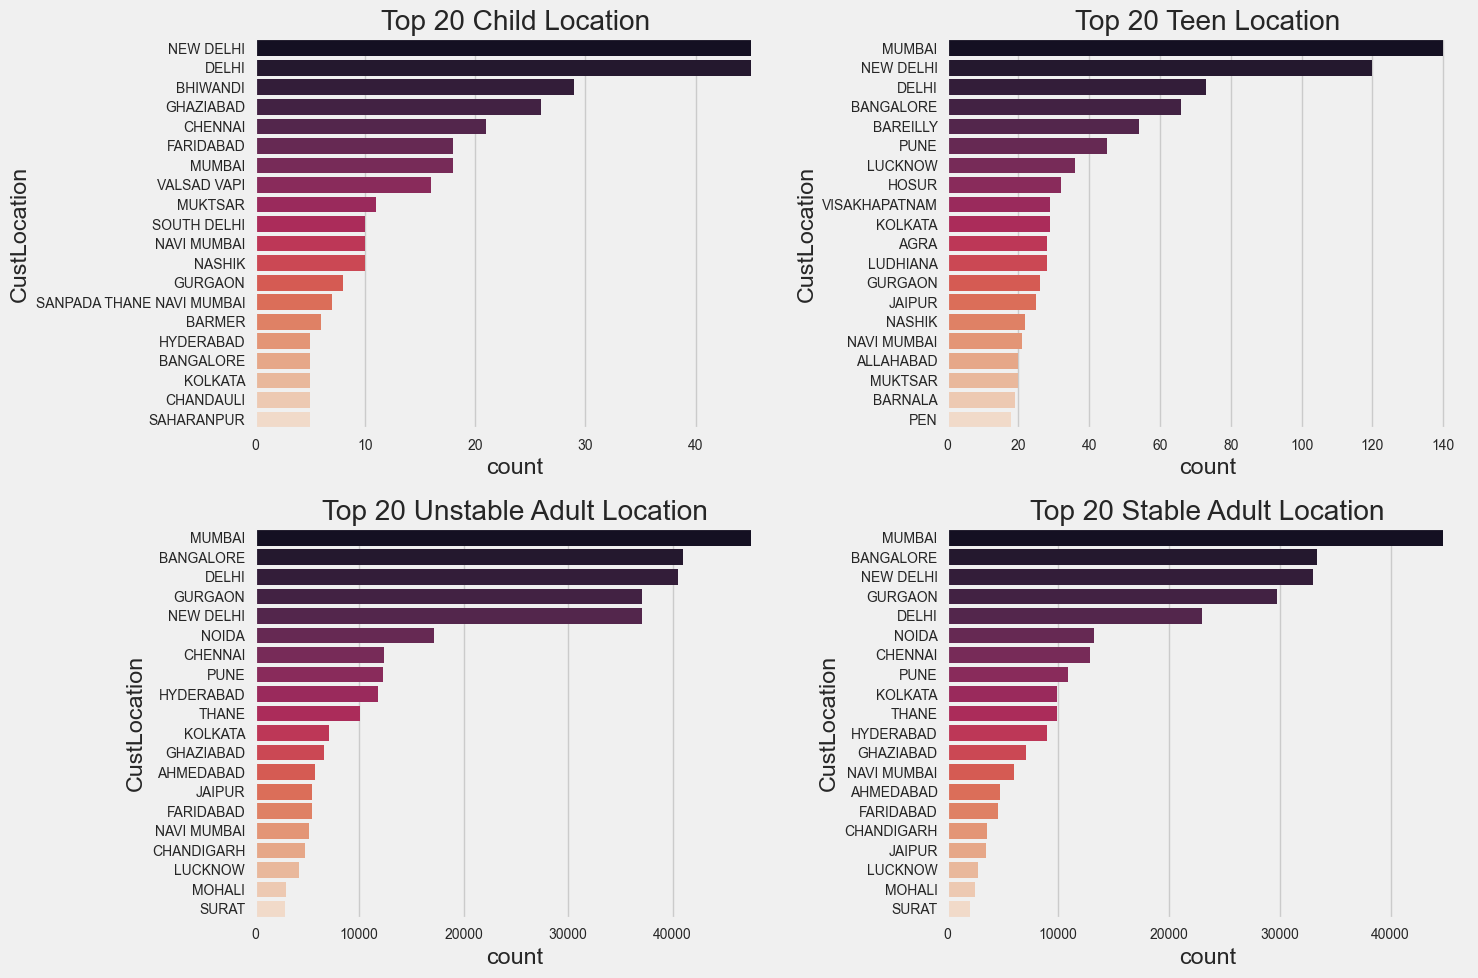

In [51]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(15,10))
palette_color = sns.color_palette('rocket')
sns.countplot(y='CustLocation',data=child_df,palette='rocket', order = child_df['CustLocation'].value_counts()[:20].index, ax=ax[0][0])
sns.countplot(y='CustLocation',data=teen_df,palette='rocket', order = teen_df['CustLocation'].value_counts()[:20].index, ax=ax[0][1])
sns.countplot(y='CustLocation',data=unstable_adult_df,palette='rocket', order = unstable_adult_df['CustLocation'].value_counts()[:20].index, ax=ax[1][0])
sns.countplot(y='CustLocation',data=stable_adult_df,palette='rocket', order = stable_adult_df['CustLocation'].value_counts()[:20].index, ax=ax[1][1])
ax[0][0].set_title("Top 20 Child Location")
ax[0][1].set_title("Top 20 Teen Location")
ax[1][0].set_title("Top 20 Unstable Adult Location")
ax[1][1].set_title("Top 20 Stable Adult Location")
plt.tight_layout()

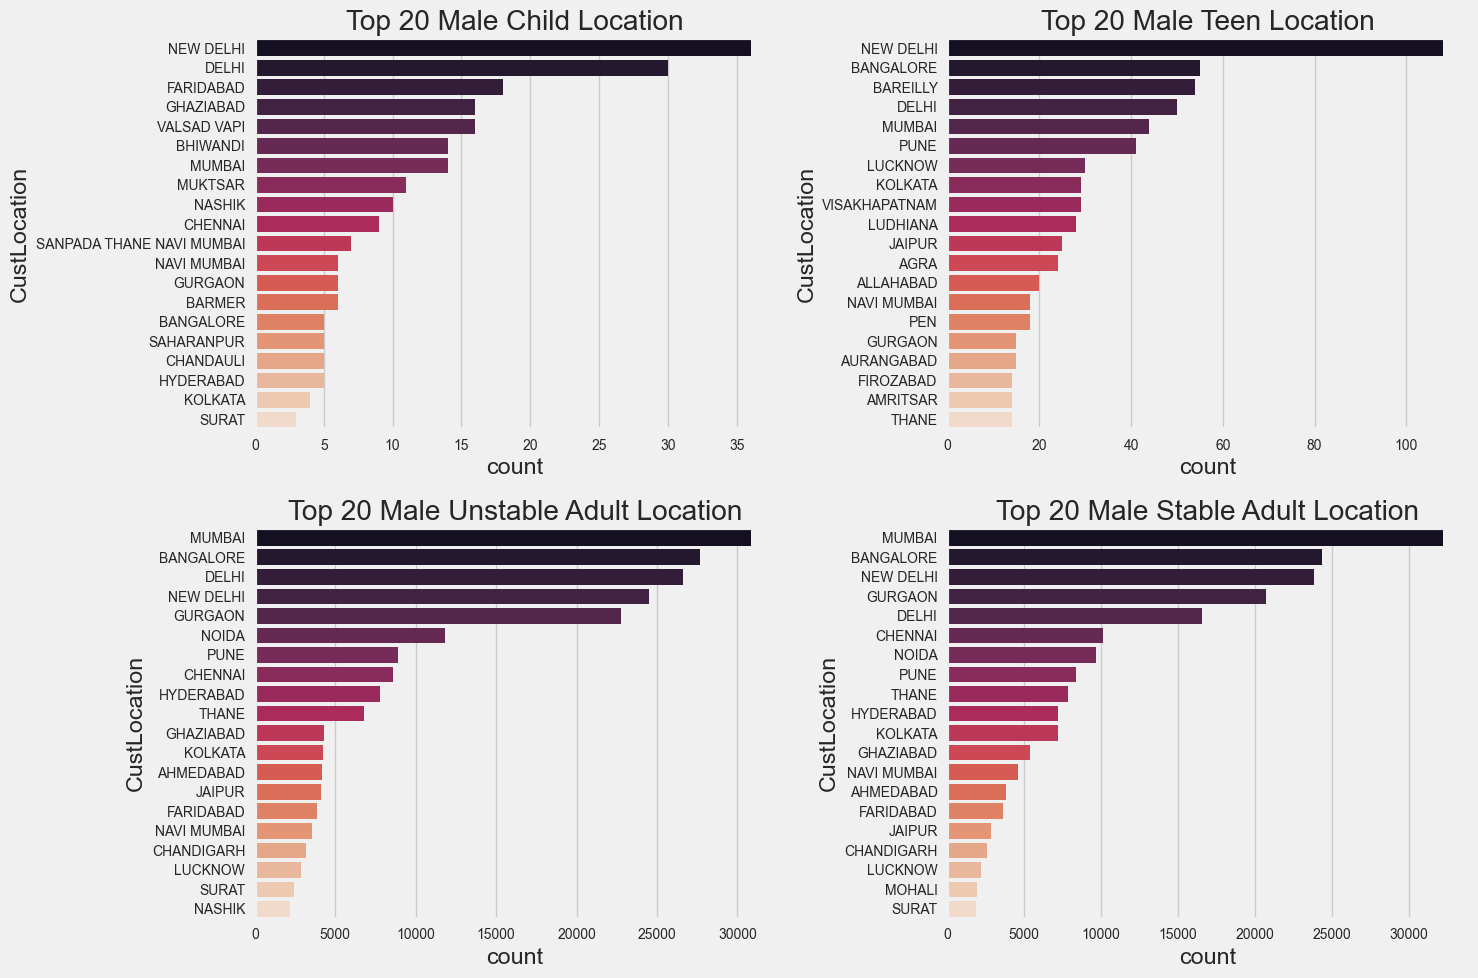

In [52]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(15,10))
palette_color = sns.color_palette('rocket')
sns.countplot(y='CustLocation',data=male_child_df,palette='rocket', order = male_child_df['CustLocation'].value_counts()[:20].index, ax=ax[0][0])
sns.countplot(y='CustLocation',data=male_teen_df,palette='rocket', order = male_teen_df['CustLocation'].value_counts()[:20].index, ax=ax[0][1])
sns.countplot(y='CustLocation',data=male_unstable_adult_df,palette='rocket',
              order = male_unstable_adult_df['CustLocation'].value_counts()[:20].index, ax=ax[1][0])
sns.countplot(y='CustLocation',data=male_stable_adult_df,palette='rocket',
              order = male_stable_adult_df['CustLocation'].value_counts()[:20].index, ax=ax[1][1])
ax[0][0].set_title("Top 20 Male Child Location")
ax[0][1].set_title("Top 20 Male Teen Location")
ax[1][0].set_title("Top 20 Male Unstable Adult Location")
ax[1][1].set_title("Top 20 Male Stable Adult Location")
plt.tight_layout()

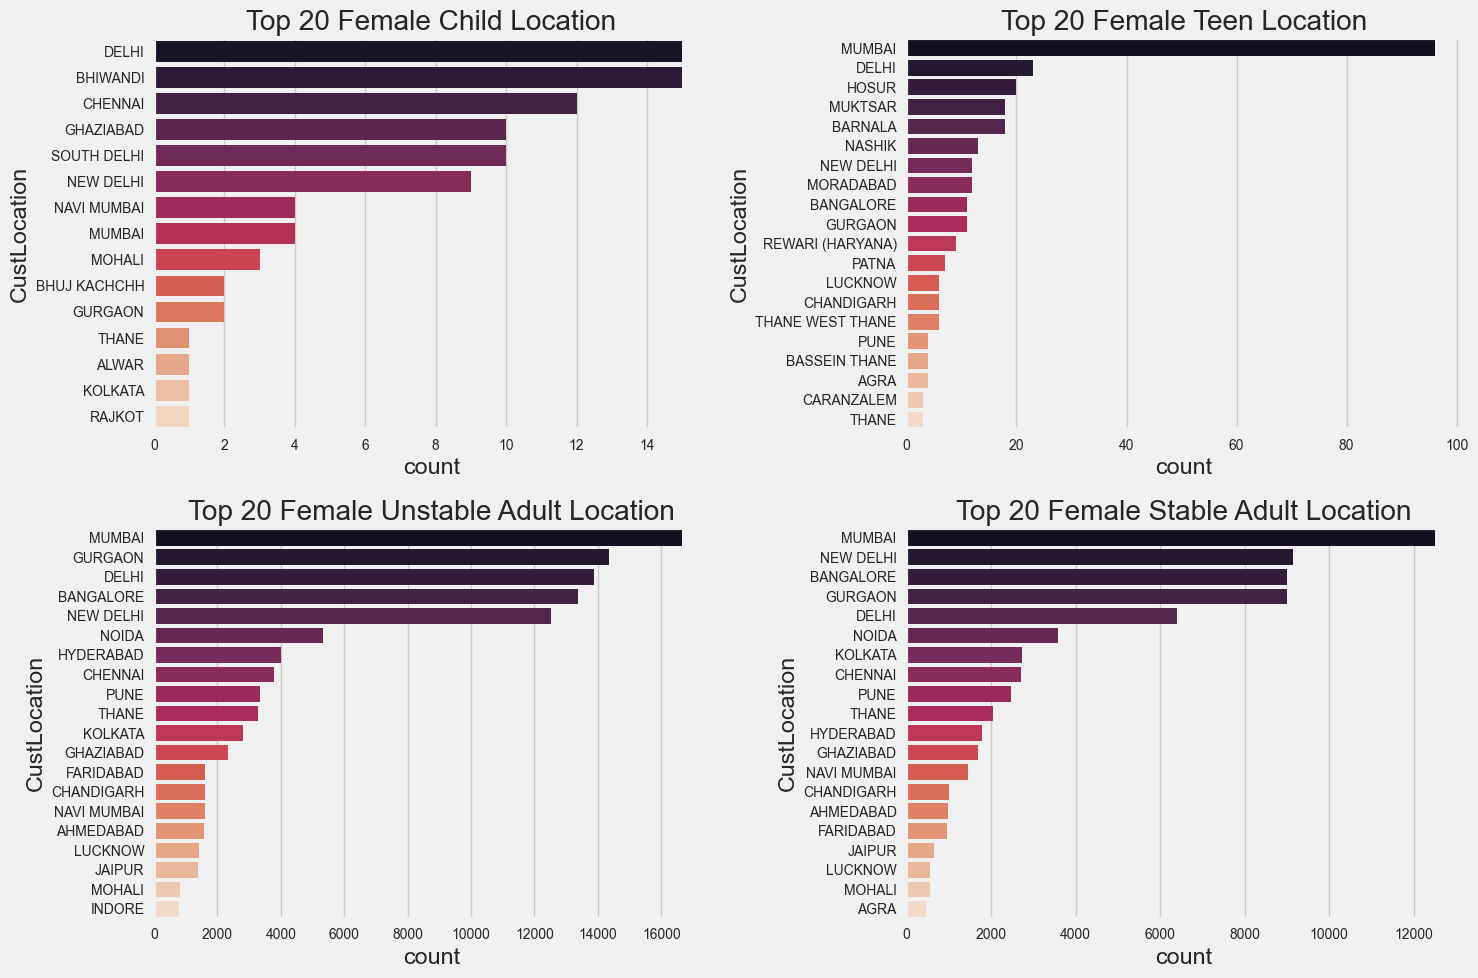

In [53]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(15,10))
palette_color = sns.color_palette('rocket')
sns.countplot(y='CustLocation',data=female_child_df,palette='rocket', order = female_child_df['CustLocation'].value_counts()[:20].index, ax=ax[0][0])
sns.countplot(y='CustLocation',data=female_teen_df,palette='rocket', order = female_teen_df['CustLocation'].value_counts()[:20].index, ax=ax[0][1])
sns.countplot(y='CustLocation',data=female_unstable_adult_df,palette='rocket',
              order = female_unstable_adult_df['CustLocation'].value_counts()[:20].index, ax=ax[1][0])
sns.countplot(y='CustLocation',data=female_stable_adult_df,palette='rocket',
              order = female_stable_adult_df['CustLocation'].value_counts()[:20].index, ax=ax[1][1])
ax[0][0].set_title("Top 20 Female Child Location")
ax[0][1].set_title("Top 20 Female Teen Location")
ax[1][0].set_title("Top 20 Female Unstable Adult Location")
ax[1][1].set_title("Top 20 Female Stable Adult Location")
plt.tight_layout()

Text(0.5, 1.0, 'Male Transaction Amount and Age')

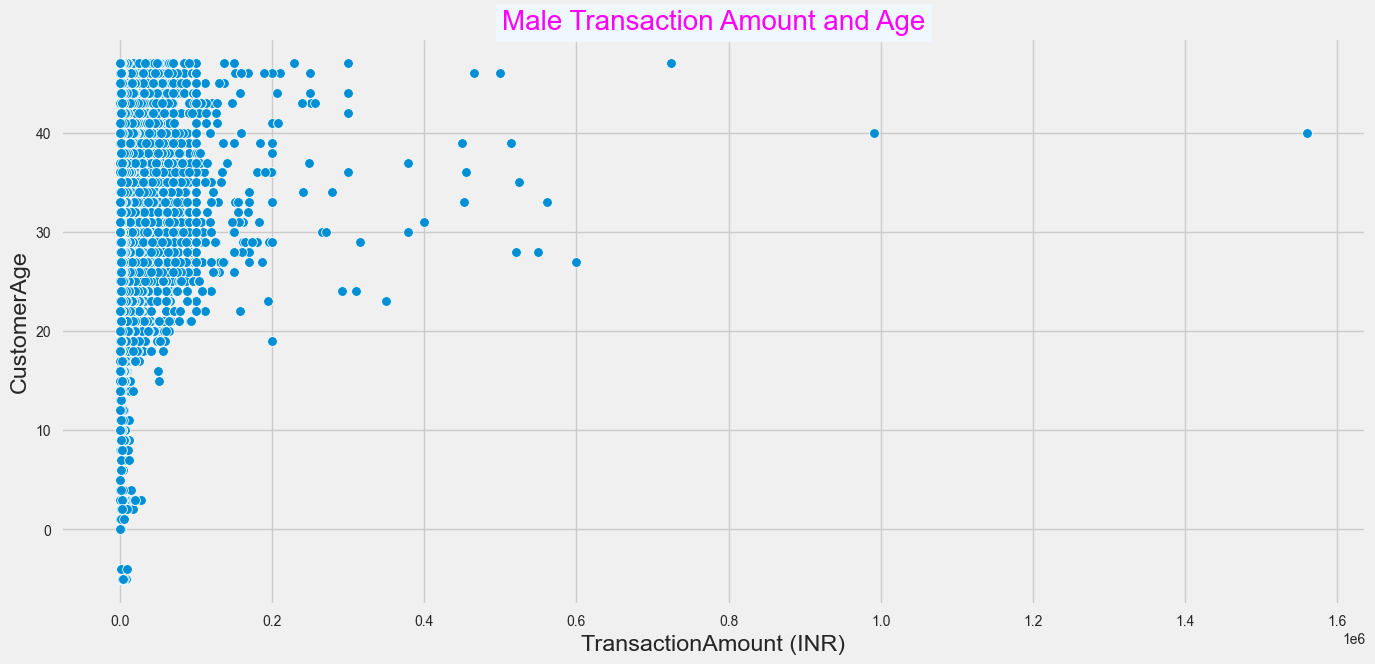

In [73]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,7))
sns.scatterplot(x='TransactionAmount (INR)',y='CustomerAge',data=male_df)
plt.title("Male Transaction Amount and Age",
          fontsize='20',
          backgroundcolor='AliceBlue',
          color='magenta')

Text(0.5, 1.0, 'Female Transaction Amount and Age')

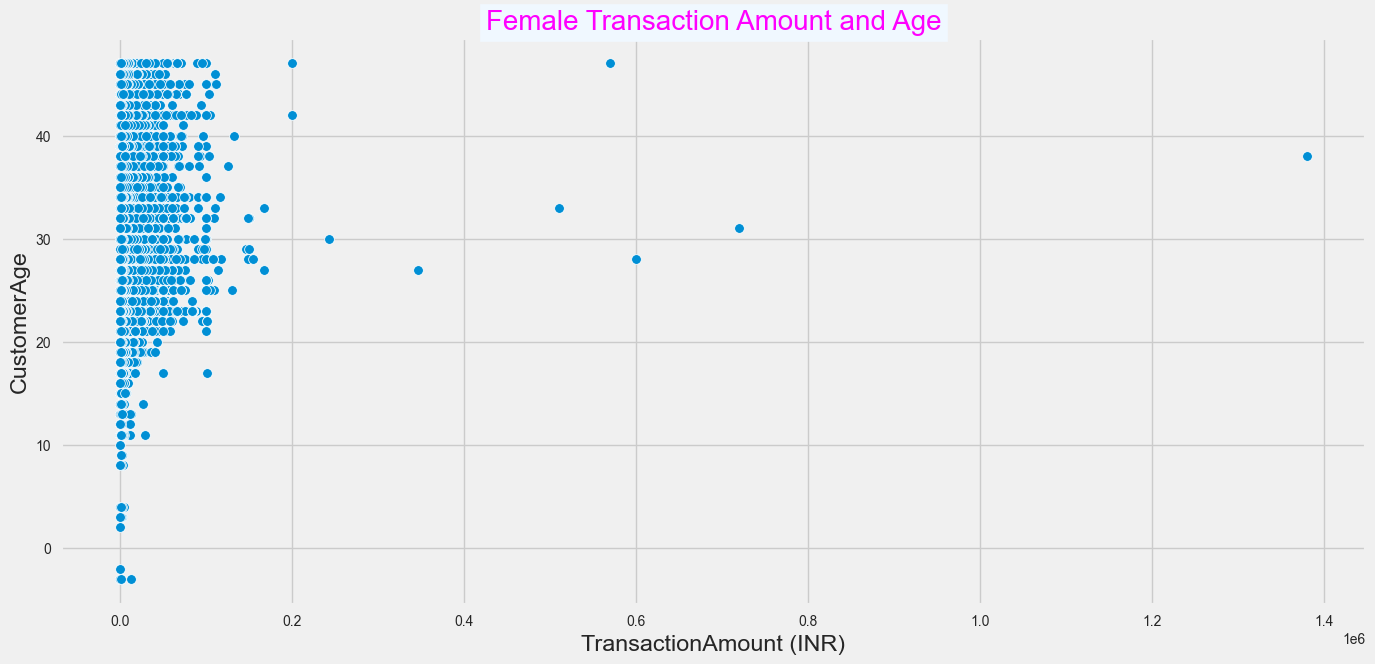

In [76]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,7))
sns.scatterplot(x='TransactionAmount (INR)',y='CustomerAge',data=female_df)
plt.title("Female Transaction Amount and Age",
          fontsize='20',
          backgroundcolor='AliceBlue',
          color='magenta')

In [79]:
# Perform Clustering / Segmentation on the dataset and identify popular customer groups along with their definition / rules
cluster_df = df.drop(columns=['TransactionID','CustomerID','CustomerDOB','CustLocation','TransactionDate'])
cluster_df['CustGender']=cluster_df['CustGender'].map({'M':1,'F':0})
cluster_df

,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge
0,0,17819.05,25.0,22
1,0,17874.44,459.0,20
2,0,866503.21,2060.0,43
3,0,6714.43,1762.5,28
4,0,53609.20,676.0,44
...,...,...,...,...
931193,1,7635.19,799.0,26
931194,1,27311.42,460.0,24
931195,1,221757.06,770.0,27
931196,1,10117.87,1000.0,38


In [84]:
# Kmeans algorithm settings
kmeans_set = {"init":"k-means++", "max_iter":300, "random_state":39}

inertias = []
silhouette_coefficients = []

for k in range(2,9):
    print("Current K",k)
    kmeans = KMeans(n_clusters=k, **kmeans_set)    # open dictionary
    kmeans.fit(cluster_df)
    inertias.append(kmeans.inertia_)
    score=silhouette_score(cluster_df, kmeans.labels_)
    silhouette_coefficients.append(score)

Current K 2


KeyboardInterrupt: 

In [ ]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(1,2,figsize=(20,5))
kl = KneeLocator(range(2,9), inertias, curve='convex', direction="decreasing")
ax[0].plot(range(2,9), inertias,color='purple',marker='o',label='Elbow Method')
ax[0].set_xticks(range(2,9))
ax[0].set_xlabel("Number of Clusters", labelpad=20)
ax[0].set_ylabel("Inertia", labelpad=20)
ax[0].set_title("Elbow Method")
ax[0].axvline(x=kl.elbow, color='black', label='axvline-fullheight', ls='--', linewidth=3)

ax[1].plot(range(2,9), silhouette_coefficients,color='purple',marker='o',label='silhouette coefficients')
ax[1].set_xticks(range(2,9))
ax[1].set_title("silhouette values")
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("silhouette_coefficients")
plt.tight_layout()

In [ ]:
kmeans = KMeans(n_clusters=?? , **kmeans_set)    
kmeans.fit(cluster_df)
cluster_df['Label']=kmeans.labels_
cluster_df.head()

In [ ]:
sns.pairplot(df_scaled,hue='Label')

In [ ]:
# TODO 2: Perform Location-wise analysis to identify regional trends

In [ ]:
# TODO 3: Perform transaction-related analysis to identify interesting trends that can be used by a bank to improve/optimize their user experience